<a href="https://colab.research.google.com/github/csataridominik/SouthKorea2025/blob/main/Ultrasound_Pixel_Intensity_Thresholding_Based_on_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HISZTOGRAM ALAPJÁN

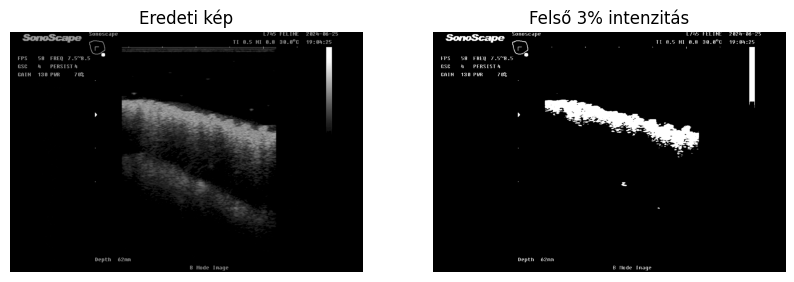

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_top_x_percent(image_path):
    # Kép betöltése szürkeárnyalatosként
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Hisztogram számítása
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0,256])

    # Kumulatív eloszlás számítása
    cdf = hist.cumsum()
    #print(cdf)
    cdf_normalized = cdf / cdf[-1]  # Normalizált kumulatív eloszlás
    #print(cdf_normalized)

    # Küszöbérték meghatározása a felső 3-4%-hoz
    threshold_value = np.where(cdf_normalized >= 0.96)[0][0]

    # Maszk létrehozása: csak azok a pixelek maradnak, amelyek a felső 20%-ba esnek
    mask = image >= threshold_value
    output = np.zeros_like(image)
    output[mask] = 255  # A magas intenzitású pixelek fehérek lesznek, a többi fekete

    return image, output, threshold_value

# Futtatás
image_path = "ultrahang_screen2.png"  # Cseréld ki a saját fájlodra
#image_path = "ultrasound4.png"
original, processed, threshold = extract_top_x_percent(image_path)

# Ábrázolás
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Eredeti kép
axs[0].imshow(original, cmap="gray")
axs[0].axis("off")
axs[0].set_title("Eredeti kép")

# Feldolgozott kép
axs[1].imshow(processed, cmap="gray")
axs[1].axis("off")
axs[1].set_title("Felső 3% intenzitás")

plt.show()

In [42]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import Colab-specific function

def find_left_up(main_img):
  # Load main image in grayscale


  # Define the template (kernel) from the main image
  #kernel = main_img[61:79, 25:43].copy()

  kernel = cv2.imread("kernel.png", cv2.IMREAD_GRAYSCALE)
  # Apply template matching
  result = cv2.matchTemplate(main_img, kernel, cv2.TM_CCOEFF_NORMED)

  # Get the best match location
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

  return max_loc
  # Draw a rectangle around the detected template
  # h, w = kernel.shape  # Get dimensions of the template
  # top_left = max_loc  # Best match location
  # bottom_right = (top_left[0] + w, top_left[1] + h)

  # cv2.rectangle(main_img, top_left, bottom_right, (255, 255, 255), 2)  # Draw rectangle

  # Display image in Colab (use cv2_imshow instead of cv2.imshow)
  #cv2_imshow(main_img)

  # Save the modified main image
  #cv2.imwrite("output.png", main_img)


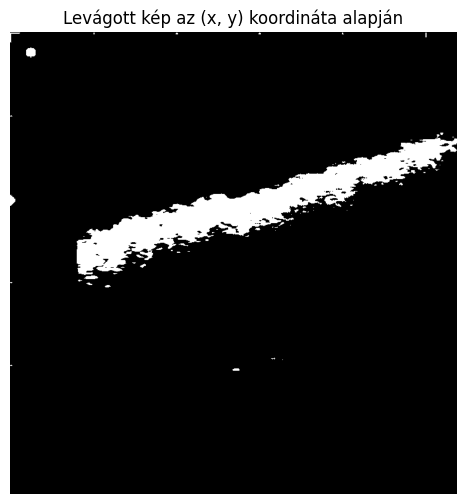

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#image_path = "ultrasound4.png"
#image_path = "ultrahang_screen3.png"
image_path = "ultrahang_screen1.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
x,y = find_left_up(image)

x2 = x+775 - 25
y2 = y+836- 60

# Levágjuk a képet az (x, y) koordináta szerint

original, processed, threshold = extract_top_x_percent(image_path)

cropped_image = processed[y:y2, x:x2].copy()  # A képet az (x, y) ponttól lefelé és jobbra vágjuk
image[y:y2, x:x2] = 0
#plt.imshow(image)




# Mentés
cropped_image_path = "cropped_image.png"
cv2.imwrite(cropped_image_path, cropped_image)

# Megjelenítés Matplotlib segítségével
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Levágott kép az (x, y) koordináta alapján")
plt.show()
